In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
import matplotlib as mpl
from cycler import cycler
mpl.rcParams["axes.prop_cycle"] = cycler(color="rgb")

## Load and prepare data.

In [24]:
relax = pd.read_csv("relax.csv", dtype={"Time": np.float64})
mpi = pd.read_csv("mpi.csv", dtype={"Time": np.float64})

In [25]:
# get average of repeated runs
relax_avg = relax.groupby("N").mean().reset_index()
mpi_avg = mpi.groupby(["N", "Cores"]).mean().reset_index()

# convert time from ms to s
relax_avg["Time"] = relax_avg.Time.div(1000)
mpi_avg["Time"] = mpi_avg.Time.div(1000)

# add row for total number of elements
fn = lambda x: (int)(x.N * x.N)
relax_avg["Size"] = relax_avg.apply(fn, axis=1)
mpi_avg["Size"] = mpi_avg.apply(fn, axis=1)

# add labels
fn = lambda x: f"MPI {int(x.Cores)} cores"
relax_avg["Label"] = "Sequential"
mpi_avg["Label"] = mpi_avg.apply(fn, axis=1)

In [26]:
relax_avg.head()

,N,Size,Iterations,Time,Label
0,100,10000,217,0.0042,Sequential
1,200,40000,365,0.0284,Sequential
2,300,90000,445,0.0800,Sequential
3,400,160000,445,0.1402,Sequential
4,500,250000,445,0.2200,Sequential


### Performance metrics.

In [27]:
# calculate flops
fn = lambda x: (9 * x.Iterations * x.N * x.N) / x.Time
relax_avg["FLOPS"] = relax_avg.apply(fn, axis=1)
mpi_avg["FLOPS"] = mpi_avg.apply(fn, axis=1)

# select only thousands
relax_small = relax_avg[relax_avg.N % 1000 == 0]
mpi_small = mpi_avg[mpi_avg.N % 1000 == 0]

In [28]:
# calculate speedup
fn = lambda x: (relax_avg.loc[relax_avg.N == x.N].iloc[0].Time) / (x.Time * x.Cores)
mpi_avg["Speedup"] = mpi_avg.apply(fn, axis=1)

# calculate efficiency
fn = lambda x: x.Speedup / x.Cores
mpi_avg["Efficiency"] = mpi_avg.apply(fn, axis=1)

In [29]:
# calculate memory usage
fn = lambda x: 2 * (x.N * x.N + 2 * x.N * (x.Cores - 1))
relax_avg["Memory"] = 2 * relax_avg.Size
mpi_avg["Memory"] = mpi_avg.apply(fn, axis=1)

In [30]:
mpi_avg.head()

,N,Cores,Size,Iterations,Time,Label,FLOPS,Speedup,Efficiency,Memory
0,100,1,10000,217,0.0040,MPI 1 cores,4.882500e+09,1.050000,1.050000,20000
1,100,2,10000,217,0.0032,MPI 2 cores,6.103125e+09,0.656250,0.328125,20400
2,100,3,10000,217,0.0024,MPI 3 cores,8.137500e+09,0.583333,0.194444,20800
3,100,4,10000,211,0.0032,MPI 4 cores,5.934375e+09,0.328125,0.082031,21200
4,100,5,10000,178,0.0026,MPI 5 cores,6.161538e+09,0.323077,0.064615,21600


## Combine data for easier processing.

In [31]:
# combine data
combined = pd.concat([relax_avg, mpi_avg])
combined = combined.fillna(0)
combined = combined.astype({"Cores": "int64"})

combined.drop("Speedup", axis=1, inplace=True)
combined.drop("Efficiency", axis=1, inplace=True)

# select only thousands
combined_small = combined[combined.N % 1000 == 0]
combined_small.reset_index(inplace=True)

In [32]:
combined.head()

,N,Size,Iterations,Time,Label,FLOPS,Memory,Cores
0,100,10000,217,0.0042,Sequential,4.650000e+09,20000,0
1,200,40000,365,0.0284,Sequential,4.626761e+09,80000,0
2,300,90000,445,0.0800,Sequential,4.505625e+09,180000,0
3,400,160000,445,0.1402,Sequential,4.570613e+09,320000,0
4,500,250000,445,0.2200,Sequential,4.551136e+09,500000,0


### Create subset containing less core counts.

In [33]:
cores = [0, 1, 2, 4, 8]
subset = combined[combined.Cores.isin(cores)]
subset_small = combined_small[combined_small.Cores.isin(cores)]
subset_small.reset_index(inplace=True)

In [34]:
subset_small.head()

,level_0,index,N,Size,Iterations,Time,Label,FLOPS,Memory,Cores
0,0,9,1000,1000000,445,1.7386,Sequential,2.303578e+09,2000000,0
1,1,19,2000,4000000,445,5.5600,Sequential,2.881295e+09,8000000,0
2,2,29,3000,9000000,445,11.9302,Sequential,3.021324e+09,18000000,0
3,3,39,4000,16000000,445,21.6916,Sequential,2.954139e+09,32000000,0
4,4,49,5000,25000000,445,33.7542,Sequential,2.966298e+09,50000000,0


---

## Plot performance.

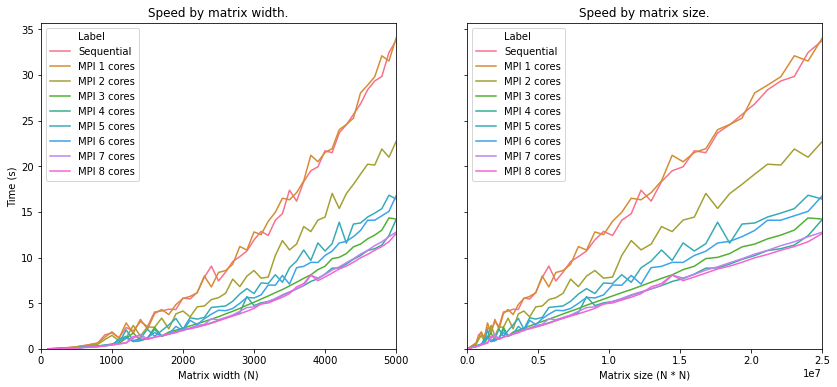

In [48]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14, 6))

sns.lineplot(x="N", y="Time", hue="Label", data=combined, ax=axs[0])
sns.lineplot(x="Size", y="Time", hue="Label", data=combined, ax=axs[1])

axs[0].set_title("Speed by matrix width.")
axs[1].set_title("Speed by matrix size.")
axs[0].set_xlabel("Matrix width (N)")
axs[1].set_xlabel("Matrix size (N * N)")
axs[0].set_ylabel("Time (s)")

axs[0].set_xlim(0, 5000)
axs[1].set_xlim(0, 5000 * 5000)
axs[0].set_ylim(bottom=0)

plt.show()

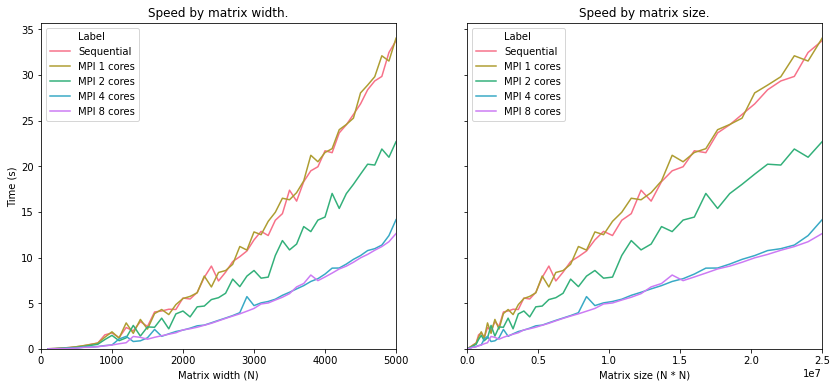

In [56]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14, 6))

sns.lineplot(x="N", y="Time", hue="Label", data=subset, ax=axs[0])
sns.lineplot(x="Size", y="Time", hue="Label", data=subset, ax=axs[1])

axs[0].set_title("Speed by matrix width.")
axs[1].set_title("Speed by matrix size.")
axs[0].set_xlabel("Matrix width (N)")
axs[1].set_xlabel("Matrix size (N * N)")
axs[0].set_ylabel("Time (s)")

axs[0].set_xlim(0, 5000)
axs[1].set_xlim(0, 5000 * 5000)
axs[0].set_ylim(bottom=0)

plt.show()

---

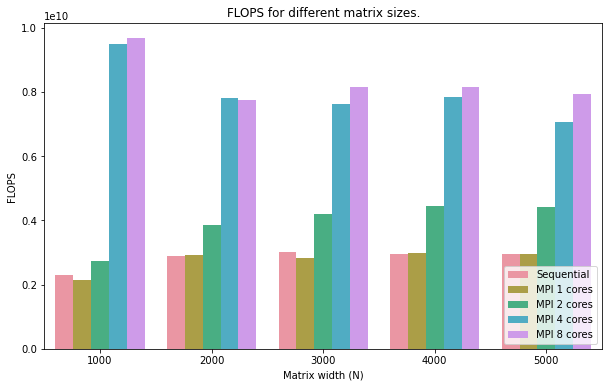

In [55]:
plt.figure(figsize=(10, 6))

ax = sns.barplot(x="N", y="FLOPS", hue="Label", data=subset_small)

ax.set_title("FLOPS for different matrix sizes.")
ax.set_xlabel("Matrix width (N)")
ax.set_ylabel("FLOPS")
plt.legend(loc="lower right")

plt.show()

## Plot improvement.

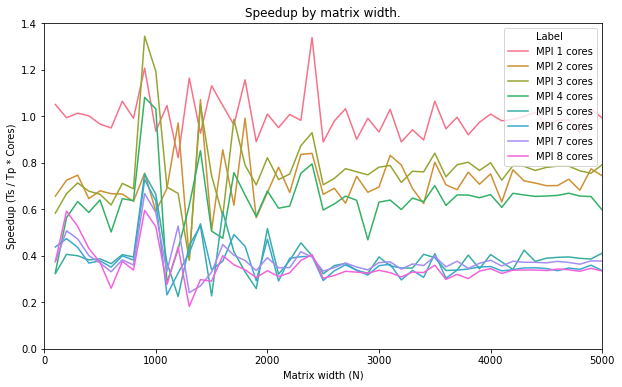

In [37]:
plt.figure(figsize=(10, 6))

ax = sns.lineplot(x="N", y="Speedup", hue="Label", data=mpi_avg)

ax.set_title("Speedup by matrix width.")
ax.set_xlabel("Matrix width (N)")
ax.set_ylabel("Speedup (Ts / Tp * Cores)")

ax.set_xlim(0, 5000)
ax.set_ylim(bottom=0)

plt.show()

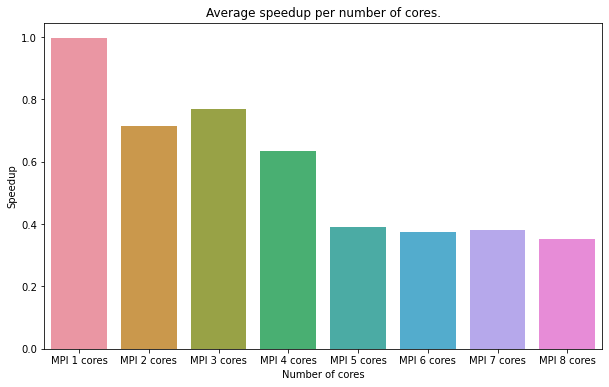

In [38]:
labels = [f"MPI {i} cores" for i in range(1, 9)]
speedup = mpi_avg.groupby("Cores").Speedup.mean()
avg_speedup = pd.DataFrame(zip(labels, speedup), columns=["Label", "Speedup"])

plt.figure(figsize=(10, 6))

ax = sns.barplot(x="Label", y="Speedup", data=avg_speedup)

ax.set_title("Average speedup per number of cores.")
ax.set_xlabel("Number of cores")
ax.set_ylabel("Speedup")

plt.show()

---

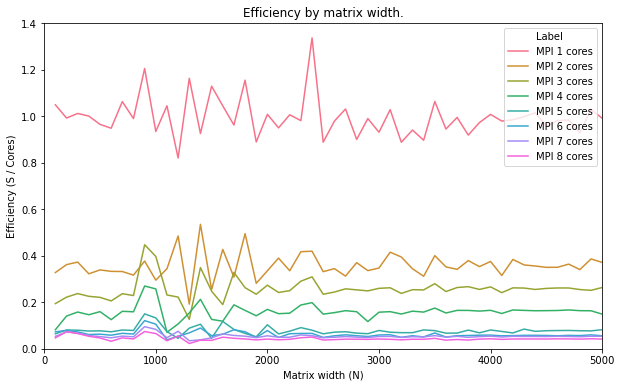

In [39]:
plt.figure(figsize=(10, 6))

ax = sns.lineplot(x="N", y="Efficiency", hue="Label", data=mpi_avg)

ax.set_title("Efficiency by matrix width.")
ax.set_xlabel("Matrix width (N)")
ax.set_ylabel("Efficiency (S / Cores)")

ax.set_xlim(0, 5000)
ax.set_ylim(bottom=0)
plt.legend(loc="upper right")

plt.show()

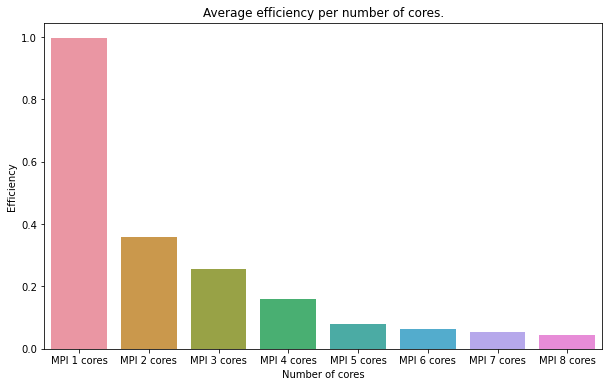

In [40]:
labels = [f"MPI {i} cores" for i in range(1, 9)]
efficiency = mpi_avg.groupby("Cores").Efficiency.mean()
avg_speedup = pd.DataFrame(zip(labels, efficiency), columns=["Label", "Efficiency"])

plt.figure(figsize=(10, 6))

ax = sns.barplot(x="Label", y="Efficiency", data=avg_speedup)

ax.set_title("Average efficiency per number of cores.")
ax.set_xlabel("Number of cores")
ax.set_ylabel("Efficiency")

plt.show()

---

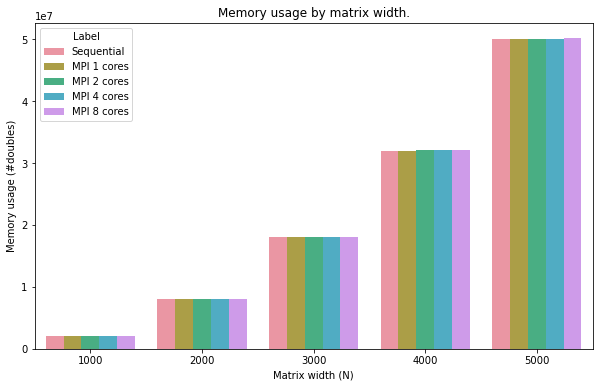

In [49]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="N", y="Memory", hue="Label", data=subset_small)

ax.set_title("Memory usage by matrix width.")
ax.set_xlabel("Matrix width (N)")
ax.set_ylabel("Memory usage (#doubles)")

plt.show()